# Example simple Boltzmann Generator

Example Boltzmann Generator with Coupling Layers trained on the double-well potential

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

First define system dimensionality and a target energy/distribution

In [3]:
dim = 2

from bgflow import DoubleWellEnergy

target = DoubleWellEnergy(dim)

Define some plotting functions

In [4]:
from bgflow.utils.types import assert_numpy

def plot_energy(energy, extent=(-2.5, 2.5), resolution=100, dim=2):
    """ Plot energy functions in 2D """
    xs = torch.meshgrid([torch.linspace(*extent, resolution) for _ in range(2)])
    xs = torch.stack(xs, dim=-1).view(-1, 2)
    xs = torch.cat([
        xs,
        torch.Tensor(xs.shape[0], dim - xs.shape[-1]).zero_()
    ], dim=-1)
    us = energy.energy(xs).view(resolution, resolution)
    us = torch.exp(-us)
    plt.imshow(assert_numpy(us).T, extent=extent * 2)
    plt.xlim=(extent[0], extent[1])
    plt.ylim=(extent[0], extent[1])


def plot_samples(samples, weights=None, range=None):
    """ Plot sample histogram in 2D """
    samples = assert_numpy(samples)
    plt.hist2d(
        samples[:, 0], 
        -samples[:, 1],
        weights=assert_numpy(weights) if weights is not None else weights,
        bins=100,
        norm=mpl.colors.LogNorm(),
        range=range
    )
    
def plot_bg(bg, target, n_samples=10000, range=[-2.5, 2.5], dim=2):
    """ Plot target energy, bg energy and bg sample histogram"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plot_energy(target, extent=range, dim=dim)
    plt.title("Target energy")
    plt.subplot(1, 3, 2)
    plot_energy(bg, extent=range, dim=dim)
    plt.title("BG energy")
    plt.subplot(1, 3, 3)
    plot_samples(bg.sample(n_samples), range=[range, range])
    plt.title("BG samples")

def plot_weighted_energy_estimate(bg, target, n_samples=100000, extent=None, n_bins=100, range=[-2, 2], dim=dim):
    """ Plot weighed energy from samples """
    samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True)
    log_weights = bg.log_weights_given_latent(samples, latent, dlogp)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=None, density=True, label="samples", range=range)
    xs = torch.linspace(*range, n_bins).view(-1, 1)
    xs = torch.cat([xs, torch.zeros(xs.shape[0], dim - 1)], dim=-1).view(-1, dim)
    us = target.energy(xs).view(-1)
    us = torch.exp(-us)
    us = us / torch.sum(us * (bins[-1] - bins[0]) / n_bins)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.ylabel("log density")
    plt.legend()
    plt.title("unweighed energy")
    
    plt.subplot(1, 3, 2)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=assert_numpy(log_weights.exp()), density=True, label="samples", range=range)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.legend()
    plt.title("weighed energy")

    plt.subplot(1, 3, 3)
    plt.xlabel("$x0$")
    plt.ylabel("$x1$")
    plot_samples(samples, weights=log_weights.exp(), range=[range, range])
    plt.title("weighed samples")

Plot target energy

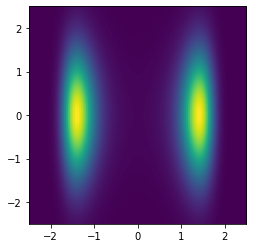

In [5]:
plot_energy(target, dim=dim)

Define a MCMC sampler to sample from the target energy

In [6]:
from bgflow import GaussianMCMCSampler

init_state = torch.Tensor([[-2, 0], [2, 0]])
init_state = torch.cat([init_state, torch.Tensor(init_state.shape[0], dim-2).normal_()], dim=-1)
target_sampler = GaussianMCMCSampler(target, init_state=init_state)

Sample some data 

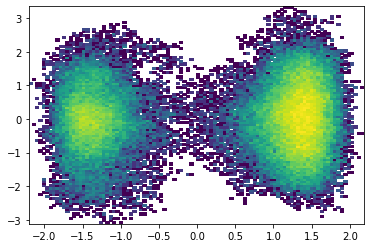

In [7]:
data = target_sampler.sample(50000)

plot_samples(data)

In [8]:
data.pow(2).sum(dim=-1).sqrt().mean()

tensor(1.5908)

Set up a prior distribution

In [9]:
from bgflow import NormalDistribution

prior = NormalDistribution(dim)

Now we define a flow with RNVP coupling layers

In [10]:
from bgflow.nn import (
    DenseNet,
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow, 
    InverseFlow, 
    SwapFlow,
    AffineTransformer
)



# here we aggregate all layers of the flow
layers = []

# start with a splitting layer which splits the input tensor into two 
# flow channels with tensors of half dimensionality
layers.append(SplitFlow(dim // 2))


# now add coupling layers
n_coupling_layers = 4
for _ in range(n_coupling_layers):
    
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        # we use a affine transformation to transform the RHS conditioned on the LHS
        AffineTransformer(
            # use simple dense nets for the affine shift/scale
            shift_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU()), 
            scale_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU())
        )
    ))
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow(dim // 2)))
    
# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers)

This is all we need to define a Boltzmann Generator

In [11]:
from bgflow import BoltzmannGenerator

bg = BoltzmannGenerator(prior, flow, target)

Lets see what our initial Boltzmann Generator is able to produce

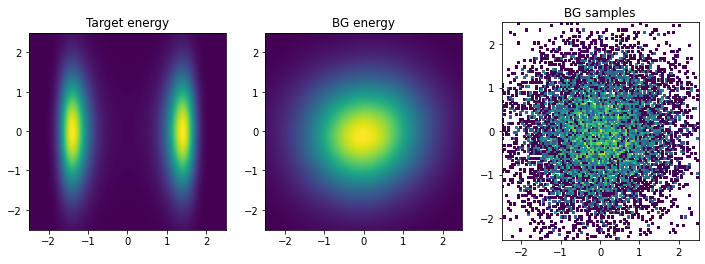

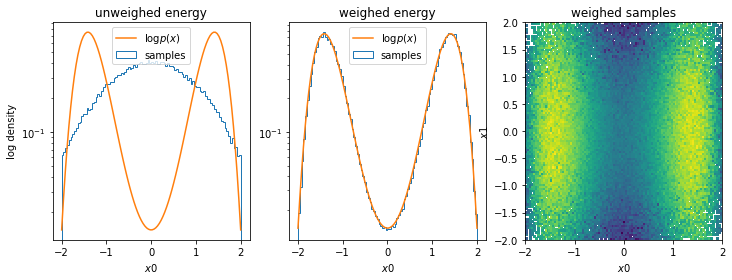

In [12]:
plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target)

As can be seen it is not very useful so far. It needs to be trained first.

We start with likelihood maximization on data set

In [13]:
from bgflow.utils import LossReporter, IndexBatchIterator

n_batch = 32
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 5
n_report_steps = 50

reporter = LossReporter("NLL")

In [14]:
for epoch in range(n_epochs):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs]
        
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        nll.backward()
        
        reporter.report(nll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, NLL: {3:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    *reporter.recent(1).ravel()
                ), end="")
        


epoch: 4, iter: 3100/3125, NLL: 2.041

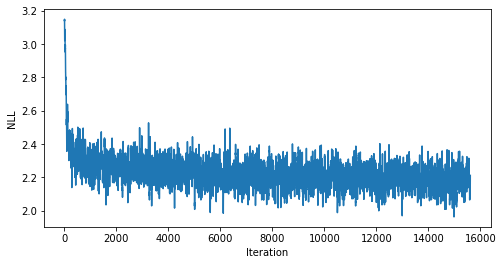

In [15]:
reporter.plot()

After this initial training the Boltzmann Generator fits the target distribution already quite well.

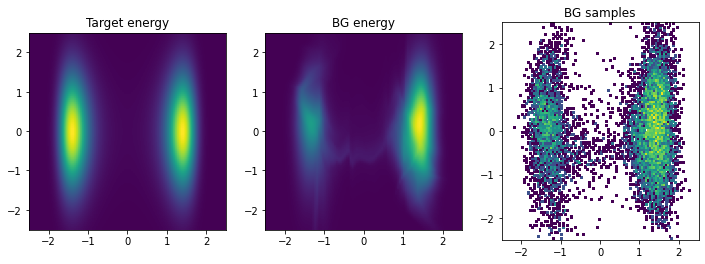

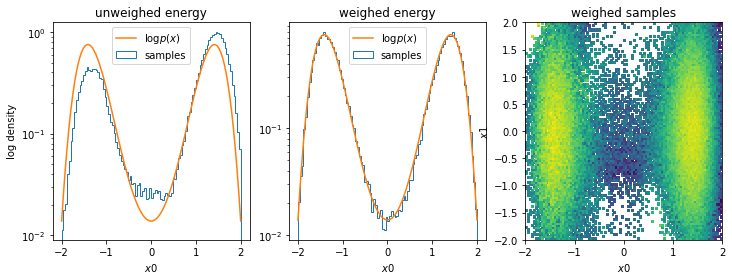

In [16]:
plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target, dim=dim)

This can usually be improved by training with a mixture of likelihood and energy based training. The latter is possible if we have access to the target energy.

In [17]:
n_kl_samples = 128
n_batch = 128
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 5
n_report_steps = 50

# mixing parameter
lambdas = torch.linspace(1., 0.5, n_epochs)

reporter = LossReporter("NLL", "KLL")

In [18]:
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs]
        
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        
        # aggregate weighted gradient
        (lamb * nll).backward()
        
        # kl divergence to the target
        kll = bg.kldiv(n_kl_samples).mean()

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")

epoch: 4, iter: 750/781, lambda: 0.5, NLL: 2.252, KLL: -2.43223

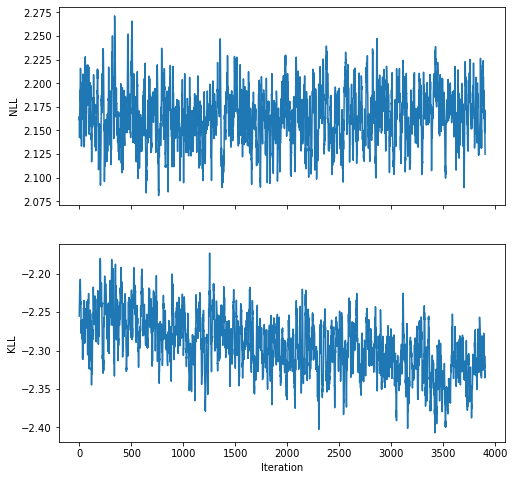

In [19]:
reporter.plot()

This is the final result after the mixed training.

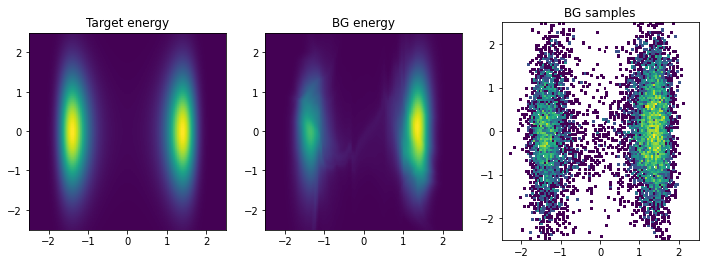

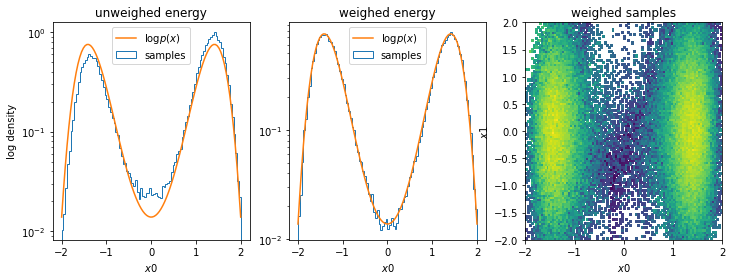

In [20]:
plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target, dim=dim)